In [51]:
import mne
from mne.datasets import visual_92_categories
data_path = visual_92_categories.data_path()


In [ ]:
## https://mne.tools/dev/auto_examples/decoding/decoding_rsa.html#sphx-glr-auto-examples-decoding-decoding-rsa-py

In [52]:
import os.path as op
import numpy as np
from pandas import read_csv
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.manifold import MDS

import mne
from mne.io import read_raw_fif, concatenate_raws

In [53]:
## Define stimulus - trigger mapping
fname = op.join(data_path, 'visual_stimuli.csv')
conds = read_csv(fname)
print(conds.head(5))
print(conds.tail(5))

   trigger       condition  human  face  animal  natural
0        0  human bodypart      1     0       1        1
1        1  human bodypart      1     0       1        1
2        2  human bodypart      1     0       1        1
3        3  human bodypart      1     0       1        1
4        4  human bodypart      1     0       1        1
    trigger             condition  human  face  animal  natural
87       87  artificial inanimate      0     0       0        0
88       88  artificial inanimate      0     0       0        0
89       89  artificial inanimate      0     0       0        0
90       90  artificial inanimate      0     0       0        0
91       91  artificial inanimate      0     0       0        0


In [54]:
## restrict number of conditions: 
max_trigger = 24
conds = conds[:max_trigger]  # take only the first 24 rows

In [55]:
print(conds) # 12 human bodypart, 12 human face. 
print(conds)

    trigger       condition  human  face  animal  natural
0         0  human bodypart      1     0       1        1
1         1  human bodypart      1     0       1        1
2         2  human bodypart      1     0       1        1
3         3  human bodypart      1     0       1        1
4         4  human bodypart      1     0       1        1
5         5  human bodypart      1     0       1        1
6         6  human bodypart      1     0       1        1
7         7  human bodypart      1     0       1        1
8         8  human bodypart      1     0       1        1
9         9  human bodypart      1     0       1        1
10       10  human bodypart      1     0       1        1
11       11  human bodypart      1     0       1        1
12       12      human face      1     1       1        1
13       13      human face      1     1       1        1
14       14      human face      1     1       1        1
15       15      human face      1     1       1        1
16       16   

In [56]:
## stimulus trigger mapping: 
conditions = []
for c in conds.values:
    cond_tags = list(c[:2]) ## 0-23 and either 
    cond_tags += [('not-' if i == 0 else '') + conds.columns[k]
                  for k, i in enumerate(c[2:], 2)] ## adds "not" when there is 0 in dummy.
    conditions.append('/'.join(map(str, cond_tags)))
print(conditions[:10])

['0/human bodypart/human/not-face/animal/natural', '1/human bodypart/human/not-face/animal/natural', '2/human bodypart/human/not-face/animal/natural', '3/human bodypart/human/not-face/animal/natural', '4/human bodypart/human/not-face/animal/natural', '5/human bodypart/human/not-face/animal/natural', '6/human bodypart/human/not-face/animal/natural', '7/human bodypart/human/not-face/animal/natural', '8/human bodypart/human/not-face/animal/natural', '9/human bodypart/human/not-face/animal/natural']


In the above cell we are looping over each row (image/trial) in our conditions array. 
The first two columns are the ID of the image and the condition while the last four columns are dummy-columns indicating whether some feature is present (e.g. face = 1 or not-face = 0). 
We turn this array into a list with the values of the six different columns (now in text instead of in 0/1 encoding) for each image. 

In [57]:
## turn them into a dictionary: 
event_id = dict(zip(conditions, conds.trigger + 1))
event_id['0/human bodypart/human/not-face/animal/natural']

1

In [58]:
## read MEG data 
n_runs = 1 # 4 for full data (use less to speed up computations)
fname = op.join(data_path, 'sample_subject_%i_tsss_mc.fif')
raws = [read_raw_fif(fname % block, verbose='error')
        for block in range(n_runs)]  # ignore filename warnings
raw = concatenate_raws(raws)

events = mne.find_events(raw, min_duration=.002)

events = events[events[:, 2] <= max_trigger]

1374 events found
Event IDs: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93 200 222 244]


In [59]:
## epoch data
picks = mne.pick_types(raw.info, 
                       meg=True)
epochs = mne.Epochs(raw, 
                    events=events, 
                    event_id=event_id, ## here we have specified our IDs. 
                    baseline=None,
                    picks=picks, 
                    tmin=-.1, 
                    tmax=.500, 
                    preload=True)


Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
Loading data for 240 events and 601 original time points ...
0 bad epochs dropped


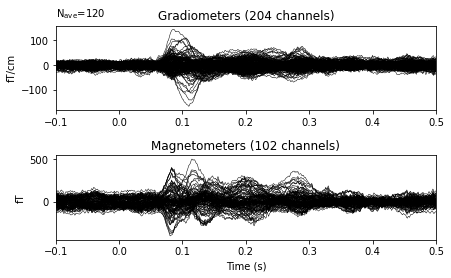

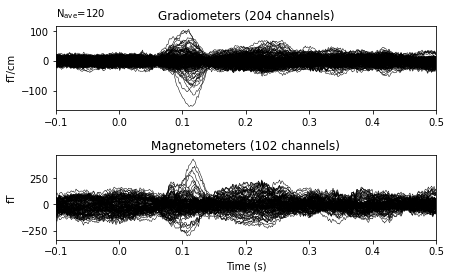

In [60]:
epochs['face'].average().plot();
epochs['not-face'].average().plot();

"Representational Similarity Analysis (RSA) is a neuroimaging-specific appelation to refer to statistics applied to the confusion matrix also referred to as the representational dissimilarity matrices (RDM).

Compared to the approach from Cichy et al. we’ll use a multiclass classifier (Multinomial Logistic Regression) while the paper uses all pairwise binary classification task to make the RDM. Also we use here the ROC-AUC as performance metric while the paper uses accuracy. Finally here for the sake of time we use RSA on a window of data while Cichy et al. did it for all time instants separately."

In [61]:
from itertools import combinations
from sklearn.svm import SVC

comb = list(combinations(classes, 2)) ## all good combinations.

## each picture is viewed 30 times. 
## 30 * 24 = 720 (thus the length of X and y).
X = epochs.copy().crop(0.05, 0.3).resample(200).get_data() ## downsample from 1000 to 200. 
y = epochs.events[:, 2]


In [67]:
X.shape ## 720 pictures, 306 sensors, 50 timepoints. Too few timepoints??

## create the object which we will put data into.  
resultMatrix = np.empty([24, 24, X.shape[-1]])

In [70]:
resultMatrix[0, 1] = 1

In [72]:
resultMatrix[:, :, 20]

array([[ 3.34327046e+064,  1.00000000e+000,  1.53776477e+171,
         2.03861513e-080,  1.18081044e+036,  3.69613636e-057,
         5.02322327e+098,  1.15372021e+272,  3.06191208e+073,
         3.20581268e+006,  1.13425426e-042,  5.74866856e+015,
         2.75539414e+194,  3.68064233e+117,  1.22242217e+059,
         1.53740730e+272,  4.18640807e+242,  1.67560756e+243,
         2.41399959e-071,  3.82795088e+006,  1.20535943e-075,
         5.57380639e+223,  2.06001318e+184,  3.39483376e+233],
       [ 7.41964553e+247,  1.90055797e+276,  4.92863824e+074,
         1.33780919e+118,  2.53399666e+108,  5.83051771e+218,
         2.81670705e+011,  2.50109345e-057,  3.69978624e+068,
         1.28290629e-061,  1.27790378e+118,  1.65265217e+093,
         1.19464165e+272,  6.80654412e+122,  2.99613256e+102,
         1.95504178e+060,  3.01543746e+233,  1.69948116e+016,
         1.66026419e+040,  7.46115554e+193,  1.04778879e+242,
         1.01688258e+088,  3.88251909e+174,  2.09462016e+064],
      

In [74]:
cond_0, cond_1 = 0, 1 

epochs['1']
epochs #10 epochs of each. 


<Epochs |  240 events (all good), -0.1 - 0.5 sec, baseline off, ~343.4 MB, data loaded,
 '0/human bodypart/human/not-face/animal/natural': 10
 '1/human bodypart/human/not-face/animal/natural': 10
 '10/human bodypart/human/not-face/animal/natural': 10
 '11/human bodypart/human/not-face/animal/natural': 10
 '12/human face/human/face/animal/natural': 10
 '13/human face/human/face/animal/natural': 10
 '14/human face/human/face/animal/natural': 10
 '15/human face/human/face/animal/natural': 10
 '16/human face/human/face/animal/natural': 10
 '17/human face/human/face/animal/natural': 10
 '18/human face/human/face/animal/natural': 10
 '19/human face/human/face/animal/natural': 10
 '2/human bodypart/human/not-face/animal/natural': 10
 '20/human face/human/face/animal/natural': 10
 '21/human face/human/face/animal/natural': 10
 '22/human face/human/face/animal/natural': 10
 '23/human face/human/face/animal/natural': 10
 '3/human bodypart/human/not-face/animal/natural': 10
 '4/human bodypart/hum

In [35]:

#### things to consider ####
## sliding estimator?
## mne.filter.resample
## stratified and taking average. 
## wrap pipeline in sliding estimator.

AttributeError: 'Epochs' object has no attribute 'shape'

In [ ]:
## sliding estimator wraps pipeline. 
from library.config import meg_dir, l_freq, N_JOBS, random_state
import mne
from mne.decoding import SlidingEstimator, cross_val_multiscore

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from mne.decoding import cross_val_multiscore

clf = make_pipeline(StandardScaler(),
                      LogisticRegression(random_state=random_state))

se = SlidingEstimator(
        clf,
        scoring='roc_auc', n_jobs=N_JOBS)

cv = StratifiedKFold(random_state=random_state)
scores = cross_val_multiscore(se, X=X, y=y, cv=cv)

In [ ]:
X = epochs["0", "1"].get_data() #now X is numpy array.. ## just resample/overwrite.
score = cross_val_multiscore(time_decod, X, y, cv = 5)

In [ ]:
y = epochs["0", "1"].events[:, 2]

In [ ]:
score = cross_val_multiscore()

In [ ]:
score.shape #5 cross each of x samples. 

In [ ]:
results[cond_0, cond_1] = score.mean(axis = 0) ## across folds axis. 

In [ ]:
results[cond_0, cond_1, : 45]

In [ ]:
plt.plot(epochs.times, results[cond_0, cond_1]) ## plot over time. 

In [102]:
from mne.decoding import SlidingEstimator, cross_val_multiscore

for i, j in comb: 
    index_list = [k for k in range(len(y)) if y[k] == i or y[k] == j]
    y_subset = y[index_list]
    X_subset = X[index_list]
    
    classes = set(y_subset)
    
    cv = StratifiedKFold(n_splits=5, 
                     random_state=0, 
                     shuffle=True)
    
    y_pred = np.zeros((len(y_subset), len(classes)))
    
    for train, test in cv.split(X, y):
        # Fit
        clf.fit(X_subset[train], y_subset[train])
        # Probabilistic prediction (necessary for ROC-AUC scoring metric)
        y_pred[test] = clf.predict(X_subset[test])
    
    


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]


[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]]
[[0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]
 [0. 0.]


In [86]:
y.shape

(720,)

In [80]:
comb[1]

(1, 3)

In [69]:
# Classify using the average signal in the window 50ms to 300ms
# to focus the classifier on the time interval with best SNR.
# using support vector machine as in Cichy original. 
from sklearn.svm import SVC
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

## each picture is viewed 30 times. 
## 30 * 24 = 720 (thus the length of X and y).
X = epochs.copy().crop(0.05, 0.3).get_data().mean(axis=2) #averaging over time perhaps. 
y = epochs.events[:, 2]

## questions: should they always be normalized (i.e. 0 and 1?)

classes = set(y)
cv = StratifiedKFold(n_splits=5, 
                     random_state=0, 
                     shuffle=True)

# Compute confusion matrix for each cross-validation fold
y_pred = np.zeros((len(y), len(classes)))
for train, test in cv.split(X, y):
    # Fit
    clf.fit(X[train], y[train])
    # Probabilistic prediction (necessary for ROC-AUC scoring metric)
    y_pred[test] = clf.predict(X[test])

ValueError: shape mismatch: value array of shape (144,) could not be broadcast to indexing result of shape (144,24)

In [28]:
#Compute confusion matrix using ROC-AUC
confusion = np.zeros((len(classes), len(classes)))
for ii, train_class in enumerate(classes): ## this is what they actually do here.. (permute).
    for jj in range(ii, len(classes)):
        confusion[ii, jj] = accuracy_score(y = train_class, 
                                           y_pred[:, jj])
        confusion[jj, ii] = confusion[ii, jj]

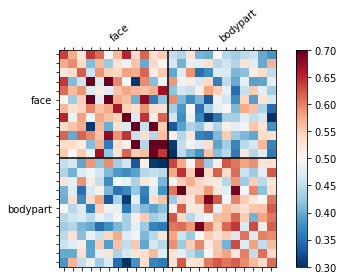

In [29]:
labels = [''] * 5 + ['face'] + [''] * 11 + ['bodypart'] + [''] * 6
fig, ax = plt.subplots(1)
im = ax.matshow(confusion, cmap='RdBu_r', clim=[0.3, 0.7])
ax.set_yticks(range(len(classes)))
ax.set_yticklabels(labels)
ax.set_xticks(range(len(classes)))
ax.set_xticklabels(labels, rotation=40, ha='left')
ax.axhline(11.5, color='k')
ax.axvline(11.5, color='k')
plt.colorbar(im)
plt.tight_layout()
plt.show()

Confusion matrix related to mental representations have been historically summarized with dimensionality reduction using multi-dimensional scaling [1]. See how the face samples cluster together.

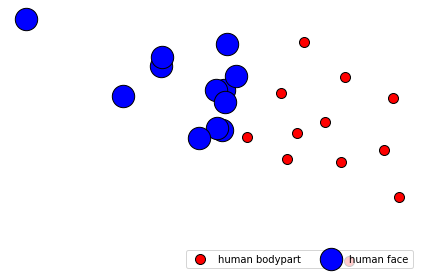

In [30]:
fig, ax = plt.subplots(1)
mds = MDS(2, random_state=0, dissimilarity='precomputed')
chance = 0.5
summary = mds.fit_transform(chance - confusion)
cmap = plt.get_cmap('rainbow')
colors = ['r', 'b']
names = list(conds['condition'].values)
for color, name in zip(colors, set(names)):
    sel = np.where([this_name == name for this_name in names])[0]
    size = 500 if name == 'human face' else 100
    ax.scatter(summary[sel, 0], summary[sel, 1], s=size,
               facecolors=color, label=name, edgecolors='k')
ax.axis('off')
ax.legend(loc='lower right', scatterpoints=1, ncol=2)
plt.tight_layout()
plt.show()